# Micrograd Implementation

A tiny Autograd engine that implements backpropagation over a dynamically built DAG (Directed Acyclic Graph). This is a pure Python implementation of a scalar-valued autograd system, similar to the one taught by Andrej Karpathy.

In [67]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [69]:
f(3.0)

20.0

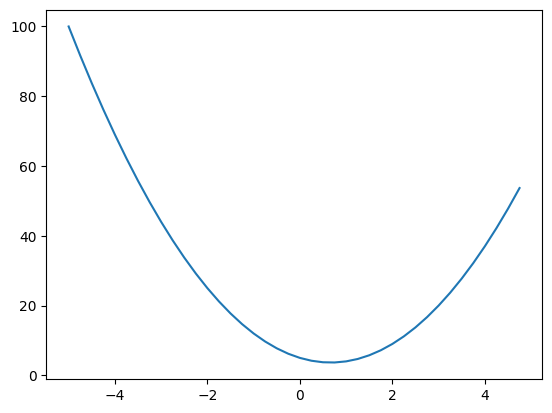

In [70]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [71]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [72]:
import math
import random
import matplotlib.pyplot as plt

class Value:
    """ Stores a single scalar value and its gradient. """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        # Internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # The addition rule: gradients are simply distributed (broadcasted)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # The product rule: d(u*v)/du = v and d(u*v)/dv = u
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            # Power rule: d(x^n)/dx = n * x^(n-1)
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            # ReLU derivative is 1 if x > 0 else 0
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # d(tanh)/dx = 1 - tanh^2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        """ Performs topological sort and applies backpropagation. """
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Go one variable at a time and apply the chain rule in reverse order
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    # --- Helper methods for Python operator overloading ---
    def __neg__(self): return self * -1
    def __sub__(self, other): return self + (-other)
    def __radd__(self, other): return self + other
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1

class Module:
    """ Base class for Neural Network components. """
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [73]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0, grad=0.0)

In [74]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

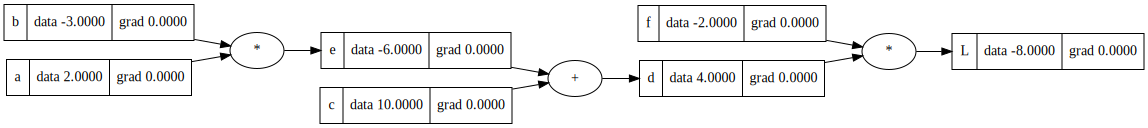

In [75]:
draw_dot(L)

In [76]:
d.grad = -2.0  # 也就是 f.data
f.grad = 4.0   # 也就是 d.data

In [77]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    # a.data += h
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    # c.data += h
    e = a*b; e.label = 'e'
    # e.data += h
    d = e+c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h)

lol()

-4.000000000008441


In [78]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o';

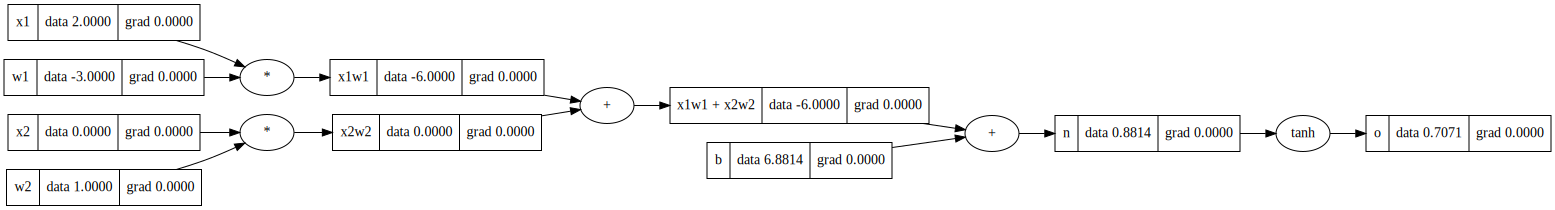

In [79]:
draw_dot(o)

In [80]:
o.backward()

In [81]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [82]:
n.grad = 0.5

In [83]:
o.grad = 1.0

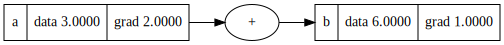

In [84]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

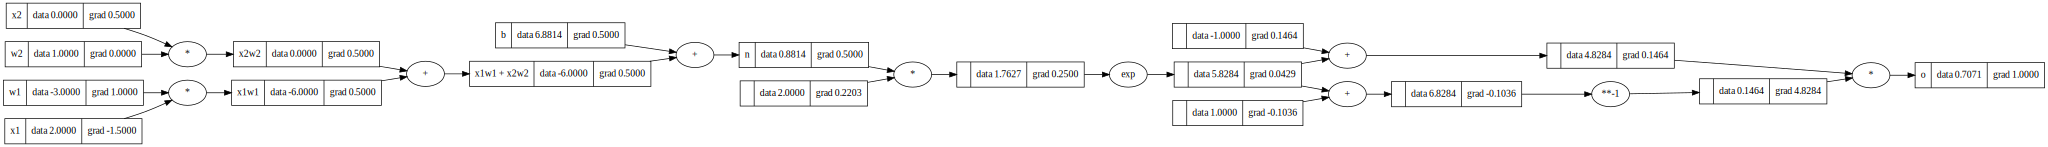

In [85]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [86]:
import torch

In [87]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

# Forward Pass
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# 
print(o.data.item())

# Backward Pass
o.backward()

# Gradients
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [88]:
class Module:
    """ Base class for Neural Network components. """
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [89]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.28301281323056504, grad=0.0)

In [90]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [91]:
for k in range(20):
    # forward
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 5.114647967729605
1 3.5600102504571494
2 3.2330365070648726
3 2.7988807126709343
4 2.341605204857792
5 1.9640588245469774
6 2.373411124813841
7 1.1704269911600638
8 0.5933673381884762
9 0.138013033971034
10 0.10837255241032376
11 0.09008558371702438
12 0.07713231022823107
13 0.06734186856580063
14 0.0596507323279013
15 0.053444873358598405
16 0.04833459965948825
17 0.04405727328700337
18 0.04042829424937864
19 0.03731374122590861


In [92]:
ypred

[Value(data=0.9432761685641666, grad=-0.11344766287166674),
 Value(data=-0.8913925378692116, grad=0.21721492426157685),
 Value(data=-0.8927735468728801, grad=0.21445290625423974),
 Value(data=0.8960622537648872, grad=-0.20787549247022552)]

step 0, loss: 2.2483
step 10, loss: 0.1250
step 20, loss: 0.0638
step 30, loss: 0.0425
step 40, loss: 0.0318


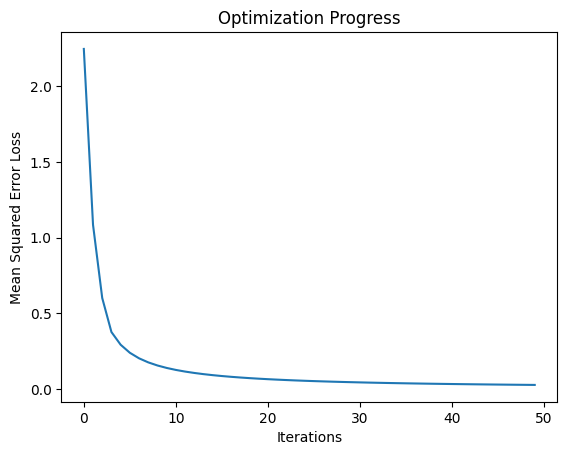

In [93]:
# Training example
n = MLP(3, [4, 4, 1])
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0] 

losses = []
for k in range(50):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Backward pass
    n.zero_grad()
    loss.backward()
    
    # Update (Stochastic Gradient Descent)
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    losses.append(loss.data)
    if k % 10 == 0:
        print(f"step {k}, loss: {loss.data:.4f}")

# Visualize the loss curve
plt.plot(losses)
plt.title('Optimization Progress')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error Loss')
plt.show()